<a href="https://colab.research.google.com/github/souro26/bayesian-a-b-testing/blob/main/v2_0_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian A/B Testing — v2.0 Demo

This notebook demonstrates **v2.0** of the Bayesian A/B testing system.

### What changed from v1.0
- v1.0 focused on **static Bayesian inference**
- v2.0 introduces a **sequential decision engine**
- Decisions are made using:
  - Practical significance (ROPE)
  - Expected loss (risk-awareness)
  - Explicit actions: SHIP / STOP / CONTINUE

### Purpose of this notebook
This notebook acts as a **demo client** for the decision engine implemented in `src/`.
It simulates an experiment over time and shows **when and why the system stops early**.



In [ ]:
!git clone https://github.com/souro26/bayesian-a-b-testing.git
%cd bayesian-a-b-testing

fatal: destination path 'bayesian-a-b-testing' already exists and is not an empty directory.
/content/bayesian-a-b-testing


In [ ]:
!pip install -r requirements.txt

In [ ]:
from src.sequential_decision import sequential_ab_decision


This is the setup cell. values in the setup cell can be changed for simulations.

In [7]:
import numpy as np

np.random.seed(42)

# True conversion rates (unknown to the algorithm)
true_p_a = 0.05
true_p_b = 0.06

# Traffic per day
users_per_day = 1000
max_days = 30

# Initialize counters
successes_a = 0
trials_a = 0
successes_b = 0
trials_b = 0


## Sequential Experiment Simulation

This cell simulates an A/B test where data arrives **day by day**.
After each day, the Bayesian decision engine is called with the cumulative data.
The experiment stops automatically once the system decides to either:
- ship the treatment (`SHIP_B`), or
- stop the experiment as futile (`STOP`).


In [8]:
# Storage for plotting
days = []
expected_lifts = []
expected_losses = []
decisions = []

print(f"Running scenario: p_A={true_p_a}, p_B={true_p_b}")
print("-" * 60)

for day in range(1, max_days + 1):
    # Simulate daily traffic
    daily_a = np.random.binomial(users_per_day, true_p_a)
    daily_b = np.random.binomial(users_per_day, true_p_b)

    # Update cumulative counts
    successes_a += daily_a
    trials_a += users_per_day

    successes_b += daily_b
    trials_b += users_per_day

    # Call the decision engine
    result = sequential_ab_decision(
        successes_a=successes_a,
        trials_a=trials_a,
        successes_b=successes_b,
        trials_b=trials_b,
    )

    # Store history
    days.append(day)
    expected_lifts.append(result["expected_lift"])
    expected_losses.append(result["expected_loss"])
    decisions.append(result["decision"])

    # Print daily status
    print(
        f"Day {day:02d} | "
        f"Lift: {result['expected_lift']:.4f} | "
        f"Loss: {result['expected_loss']:.4f} | "
        f"Decision: {result['decision']}"
    )

    # Stop experiment if decision is made
    if result["decision"] != "CONTINUE":
        print("→ Experiment concluded.")
        break


Running scenario: p_A=0.05, p_B=0.06
------------------------------------------------------------
Day 01 | Lift: 0.0129 | Loss: 0.0005 | Decision: CONTINUE
Day 02 | Lift: 0.0215 | Loss: 0.0000 | Decision: CONTINUE
Day 03 | Lift: 0.0210 | Loss: 0.0000 | Decision: SHIP_B
→ Experiment concluded.


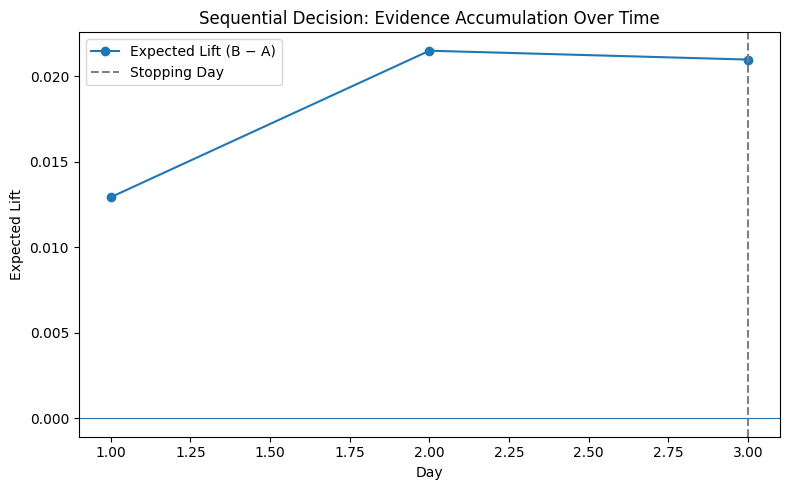

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot expected lift over time
plt.plot(
    days,
    expected_lifts,
    marker="o",
    label="Expected Lift (B − A)"
)

# Mark stopping day
stop_day = days[-1]
plt.axvline(
    stop_day,
    linestyle="--",
    color="gray",
    label="Stopping Day"
)

# Reference line at zero lift
plt.axhline(0, linewidth=0.8)

plt.xlabel("Day")
plt.ylabel("Expected Lift")
plt.title("Sequential Decision: Evidence Accumulation Over Time")
plt.legend()
plt.tight_layout()
plt.show()


**Decision Interpretation**

The expected lift evolves as data accumulates day by day.
The experiment stops automatically once the decision engine determines that
continuing to collect data is no longer valuable.

Stopping time varies across runs due to stochastic user behavior and posterior
sampling, reflecting real-world experimentation noise.
